# Author: David Dukić

# Dataset features without emoji and other categories (retweet, url, mention, hashtag) 

### Mount drive 
#### This notebook was meant to be executed on Google Colab with dataset located on Google Drive

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
path = '/content/gdrive/My Drive/Bot-Detection-and-Gender-Profiling/'

Mounted at /content/gdrive


### Necessary libraries

In [0]:
!pip install transformers
import transformers
import torch
import pandas as pd
import numpy as np

### Load dataset

In [0]:
tweets_train = pd.read_csv(path + 'train_clean_bert.csv', encoding='utf-8', names=['tweet', 'class'])
tweets_test = pd.read_csv(path + 'test_clean_bert.csv', encoding='utf-8', names=['tweet', 'class'])

train_n = len(tweets_train)

dataset = pd.concat([tweets_train, tweets_test], ignore_index=True)

length_dataset = pd.Series(dataset['tweet']).str.split(' ').str.len().sort_values(ascending=False)
print(length_dataset.describe())

print(dataset.head())
print(dataset.shape)
print(len(tweets_test))
print(set(dataset['class']))

count    474054.000000
mean         15.454860
std          20.396976
min           1.000000
25%           8.000000
50%          14.000000
75%          20.000000
max        7503.000000
Name: tweet, dtype: float64
                                               tweet   class
0                                way to go doncaster     bot
1  i ask you tonight for your vote obama i gave i...    male
2     bad temperament for pres vanity fair bombshell     bot
3  yes i got an email telling me head held high w...  female
4  software engineer for siemens software enginee...     bot
(474054, 2)
188450
{'female', 'male', 'bot'}


### Load BERT model

In [0]:
model_class, tokenizer_class, pretrained_weights = (
    transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

### Prepare tweets for BERT

In [0]:
input_ids = []
attention_masks = []

for tweet in dataset['tweet']:
  encoded_dict = tokenizer.encode_plus(
                        tweet,                    
                        add_special_tokens = True, 
                        max_length = 50,           
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt')
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

input_ids = input_ids.to('cuda')
attention_masks = attention_masks.to('cuda')
bert_model.to('cuda')

### Function to create contextualized embeddings

In [0]:
def process_part_of_dataset(input_ids, attention_masks, batch_size):
  features = []
  with torch.no_grad():
    for i in range(0, len(input_ids), batch_size):
      last_hidden_state = bert_model(input_ids[i:i+batch_size], attention_mask=attention_masks[i:i+batch_size])
      features.append(last_hidden_state[0][:,0,:].cpu().data.numpy()[0])
      if i % 1000 == 0:
        print(i)
  features = np.array(features)   
  print(features.shape)
  return features

In [0]:
features = process_part_of_dataset(input_ids, attention_masks, 1)

### Save features

In [0]:
np.save(path + 'features_50_all.npy', features)

# Tweet text combined with emoji and categories (retweet, url, mention, hashtag) 


### Mount drive

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
path = '/content/gdrive/My Drive/Bot Detection and Gender Profiling/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Install libraries

In [0]:
!pip install transformers
!pip install emoji
import transformers
import torch
import pandas as pd
import numpy as np
import emoji
import gensim.models as gsm
e2v = gsm.KeyedVectors.load_word2vec_format(path + 'emoji2vec.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Load train and test and concatenate 

In [0]:
tweets_train = pd.read_csv(path + 'train_clean_bert_extra.csv', encoding='utf-8', names=['tweet', 'emoji', 'RT', 'url', 'mention', 'hashtag', 'class'])
tweets_test = pd.read_csv(path + 'test_clean_bert_extra.csv', encoding='utf-8', names=['tweet', 'emoji', 'RT', 'url', 'mention', 'hashtag', 'class'])

train_n = len(tweets_train)

dataset = pd.concat([tweets_train, tweets_test], ignore_index=True)
dataset['human'] = dataset.apply(lambda x: 1 if x['class'] == 'female' or x['class'] == 'male' else 0, axis=1)

print("train length:", train_n)
print("test length:", len(tweets_test))
print(dataset.head())
print(dataset.shape)
print(set(dataset['class']))

train length: 288178
test length: 190211
                                               tweet  emoji  ...   class  human
0  spent ages on customer care they were supposed...      0  ...  female      1
1  i will defend indigenous people using animal p...      0  ...  female      1
2                                    the man himself      0  ...     bot      0
3  i got high somehow discovered that you can lik...  🤦🏾‍♂️  ...  female      1
4  a toast to anton walbrook in in the old vienna...      0  ...    male      1

[5 rows x 8 columns]
(478389, 8)
{'bot', 'female', 'male'}


### Count emoji

In [0]:
emojis = dataset[dataset['emoji'] != '0']['emoji'].tolist()
total_emojis = 0
for em in emojis:
  emoji_list = []
  for char in emoji.get_emoji_regexp().split(em.strip()):
    if char.strip():
      total_emojis += 1
      emoji_list.append(char)

print(total_emojis)

77573


### Get emoji vectors

In [0]:
def create_emoji_features(em):
  emoji_miss = 0
  vector_sum = np.zeros(300)
  for char in emoji.get_emoji_regexp().split(em.strip()):
    if char.strip():
      try:
        vector = e2v[char]
      except:
        emoji_miss += 1
      else:
        vector_sum += vector
  return vector_sum, emoji_miss

### Load BERT model

In [0]:
model_class, tokenizer_class, pretrained_weights = (
    transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

### Test dataset for missing values

In [0]:
dataset[pd.isnull(dataset['tweet'])]

tweet    emoji  RT  url  mention  hashtag   class
874      NaN     💬🌍🌏🌎   0    1        0        1    male
1174     NaN        💜   0    1        0        1  female
1473     NaN  👀👋🏻📸😍👇🏻   0    1        1        0    male
1792     NaN     👀👇🏻🔥   0    1        0        1    male
1852     NaN     👏🏽😂👏   0    1        1        0  female
...      ...      ...  ..  ...      ...      ...     ...
474766   NaN       😣😭   0    0        1        0  female
475729   NaN        💤   0    0        1        0  female
475825   NaN        0   1    0        1        1     bot
477058   NaN        😊   0    0        1        0  female
477935   NaN        🔥   0    0        1        0    male

[784 rows x 7 columns]

### Prepare tweets for BERT



In [0]:
def process_dataset_on_GPU(df):
  bert_model.to('cuda')
  features = []
  total_missed = 0
  with torch.no_grad():
    for i in range(len(df)):
      tweet = df['tweet'][i]
      emoji = df['emoji'][i]
      RT = np.array([float(df['RT'][i])])
      url = np.array([float(df['url'][i])])
      mention = np.array([float(df['mention'][i])])
      hashtag = np.array([float(df['hashtag'][i])])

      # if tweet is nan
      if tweet != tweet:
        emoji_features, misses = create_emoji_features(emoji)
        total_missed += misses
        features.append(np.concatenate((np.zeros(768), emoji_features, RT, url, mention, hashtag), axis=0))
        continue

      encoded_dict = tokenizer.encode_plus(
                        tweet,                    
                        add_special_tokens = True, 
                        max_length = 50,           
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt')
      
      input_id = torch.cat([encoded_dict['input_ids']], dim=0)
      attention_mask = torch.cat([encoded_dict['attention_mask']], dim=0)

      input_id = input_id.to('cuda')
      attention_mask = attention_mask.to('cuda')
      
      last_hidden_state = bert_model(input_id, attention_mask=attention_mask)
      feature = last_hidden_state[0][:,0,:].cpu().data.numpy()[0]
      
      if emoji != '0':
        emoji_features, misses = create_emoji_features(emoji)
        total_missed += misses
        features.append(np.concatenate((feature, emoji_features, RT, url, mention, hashtag), axis=0))
      else:
        features.append(np.concatenate((feature, np.zeros(300), RT, url, mention, hashtag), axis=0))
      
      if i % 1000 == 0:
        print(i)
  
  features = np.array(features)   
  print(features.shape)
  print("Missed: ", total_missed, "/", total_emojis)
  return features

### Create features

In [0]:
features = process_dataset_on_GPU(dataset)

### Save features

In [0]:
np.save(path + 'features_50_all_extra.npy', features)

# Train and test models

### Mount drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
path = '/content/gdrive/My Drive/Bot Detection and Gender Profiling/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Install libraries

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import pickle
import pandas as pd
import numpy as np

### Load dataset

In [3]:
tweets_train = pd.read_csv(path + 'train_clean_bert_extra.csv', encoding='utf-8', names=['tweet', 'emoji', 'RT', 'url', 'mention', 'hashtag', 'class'])
tweets_test = pd.read_csv(path + 'test_clean_bert_extra.csv', encoding='utf-8', names=['tweet', 'emoji', 'RT', 'url', 'mention', 'hashtag', 'class'])
dataset = pd.concat([tweets_train, tweets_test], ignore_index=True)
features = np.load(path + 'features_50_all_extra.npy')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-9f8a6f295fb0>", line 4, in <module>
    features = np.load(path + 'features_50_all_extra.npy')
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 453, in load
    pickle_kwargs=pickle_kwargs)
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/format.py", line 755, in read_array
    array = numpy.fromfile(fp, dtype=dtype, count=count)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurre

KeyboardInterrupt: ignored

### Get train, validation, test

In [0]:
def train_validation_test_split(X, y, train_n):
  X_train_valid, X_test = X[:train_n], X[train_n:]
  y_train_valid, y_test = y[:train_n], y[train_n:]
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_valid, X_test, y_train, y_valid, y_test

### Train, validate and test logistic regression

In [0]:
def train_test_lr(X, y, save_model_to, train_n, Cs=[2 ** i for i in range(-15, 16)]):
  print("Splitting sets into train, validation, test...\n")
  X_train, X_valid, X_test, y_train, y_valid, y_test = train_validation_test_split(X, y, train_n)

  scores = []

  print("Searching for optimal hyperparameters on validation set...")
  for C in Cs:
    print("Current hyperparameter: ", C)
    model = LogisticRegression(C=C, solver="lbfgs", max_iter=4000)
    model.fit(X_train, y_train)
    scores.append(f1_score(y_true=y_valid, y_pred=model.predict(X_valid), average='weighted'))

  best_C = Cs[scores.index(max(scores))]
  print("\nScores on validation set: ", scores)
  print("Optimized hyperparameters: ", Cs)
  print("Best C: ", best_C)

  model = LogisticRegression(C=best_C, solver="lbfgs", max_iter=4000)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  pickle.dump(model, open(save_model_to, 'wb'))

  return f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

## Bot vs. human

### Prepare X, y

In [0]:
dataset['human'] = dataset.apply(lambda x: 1 if x['class'] == 'female' or x['class'] == 'male' else 0, axis=1)
X = features[:]
X_768 = X[:,:768]
le = LabelEncoder()
y = le.fit_transform(dataset['human'])

### Only tweet

In [0]:
f1 = train_test_lr(X_768, y, path + 'lr_tweet_bot_human.sav', len(tweets_train))
print("F1-score-weighted :", f1)

### Tweet + emoji + categories

In [0]:
f1 = train_test_lr(X, y, path + 'lr_tweet_emoji_categories_bot_human.sav', len(tweets_train))
print("F1-score :", f1)

### Save weights data

In [5]:
model = pickle.load(open(path + 'lr_tweet_emoji_categories_bot_human.sav', 'rb'))
coefs = model.coef_[0]
tweet = list(coefs[:768]) + ['NA'] * 304
emoji = ['NA'] * 768 + list(coefs[768:1068]) + ['NA'] * 4
other = ['NA'] * 1068 + list(coefs[1068:]) 
with open(path + 'lr_bot_human_coefs.csv', 'w+') as file:
  for tw, em, ot in zip(tweet, emoji, other):
    file.write(str(tw) + "," + str(em) + "," + str(ot) + "\n")

1072


## Male vs. female

### Prepare X, y

In [0]:
gender_index = dataset.index[dataset['class'] != 'bot'].tolist()
gender_train_index = list(filter(lambda x: x < len(tweets_train), gender_index))
gender_test_index = list(filter(lambda x: x >= len(tweets_train), gender_index))
X = np.vstack((features[gender_train_index], features[gender_test_index]))
X_768 = X[:,:768]
le = LabelEncoder()
y = np.concatenate((le.fit_transform(dataset['class'][gender_train_index]), le.fit_transform(dataset['class'][gender_test_index])))

### Only tweet

In [0]:
f1 = train_test_lr(X_768, y, path + 'lr_tweet_male_female.sav', len(gender_train_index))
print("F1-score-weighted :", f1)

### Tweet + emoji + categories

In [0]:
f1 = train_test_lr(X, y, path + 'lr_tweet_emoji_categories_male_female.sav', len(gender_train_index))
print("F1-score-weighted :", f1)

### Save weights data

In [0]:
model = pickle.load(open(path + 'lr_tweet_emoji_categories_male_female.sav', 'rb'))
coefs = model.coef_[0]
tweet = list(coefs[:768]) + ['NA'] * 304
emoji = ['NA'] * 768 + list(coefs[768:1068]) + ['NA'] * 4
other = ['NA'] * 1068 + list(coefs[1068:]) 
with open(path + 'lr_male_female_coefs.csv', 'w+') as file:
  for tw, em, ot in zip(tweet, emoji, other):
    file.write(str(tw) + "," + str(em) + "," + str(ot) + "\n")

# Permutation tests


### Mount drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
path = '/content/gdrive/My Drive/Bot Detection and Gender Profiling/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Import libraries

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import pickle
import pandas as pd
import numpy as np
import random

### Load dataset

In [0]:
tweets_train = pd.read_csv(path + 'train_clean_bert_extra.csv', encoding='utf-8', names=['tweet', 'emoji', 'RT', 'url', 'mention', 'hashtag', 'class'])
tweets_test = pd.read_csv(path + 'test_clean_bert_extra.csv', encoding='utf-8', names=['tweet', 'emoji', 'RT', 'url', 'mention', 'hashtag', 'class'])
dataset = pd.concat([tweets_train, tweets_test], ignore_index=True)
features = np.load(path + 'features_50_all_extra.npy')

### Define permutation test function

In [0]:
def do_permutation_test(y_test, y_pred_A, y_pred_B, num_rounds=5000):
  D = abs(f1_score(y_test, y_pred_A, average='weighted') * 100 - f1_score(y_test, y_pred_B, average='weighted') * 100)
  print(D)
  counter = 0
  different_indexes = []
  for i, (y_A, y_B) in enumerate(zip(y_pred_A, y_pred_B)):
    if y_A != y_B:
      different_indexes.append(i)
  for i in range(num_rounds):
    if i % 100 == 0:
      print("round: ", i)
    y_perm_A = y_pred_A.copy()
    y_perm_B = y_pred_B.copy()
    indexes = [index for index in different_indexes if random.uniform(0, 1) <= 0.5]
    y_perm_A[indexes], y_perm_B[indexes] = y_perm_B[indexes], y_perm_A[indexes]
    if abs(f1_score(y_test, y_perm_A, average='weighted') * 100 - f1_score(y_test, y_perm_B, average='weighted') * 100) >= D:
      counter += 1
  return counter / num_rounds

### Train test split

In [0]:
def get_test_set(X, y, train_n):
  X_test = X[train_n:]
  y_test = y[train_n:]
  return X_test, y_test

## Bot vs. human 

### Logistic regression

In [0]:
dataset['human'] = dataset.apply(lambda x: 1 if x['class'] == 'female' or x['class'] == 'male' else 0, axis=1)
X = features[:]
X_768 = X[:,:768]
le = LabelEncoder()
y = le.fit_transform(dataset['human'])

In [7]:
model_A = pickle.load(open(path + 'lr_tweet_bot_human.sav', 'rb'))
model_B = pickle.load(open(path + 'lr_tweet_emoji_categories_bot_human.sav', 'rb'))
X_test_A, y_test = get_test_set(X_768, y, len(tweets_train))
X_test_B, y_test = get_test_set(X, y, len(tweets_train))
y_pred_A = model_A.predict(X_test_A)
y_pred_B = model_B.predict(X_test_B)
print(f1_score(y_test, y_pred_A, average='weighted'))
print(f1_score(y_test, y_pred_B, average='weighted'))

0.7771686146694522
0.8335813394487342


In [8]:
print("p-value: ", do_permutation_test(y_test, y_pred_A, y_pred_B, num_rounds=100000))

5.6412724779282115
round:  0
round:  100
round:  200
round:  300
round:  400
round:  500
round:  600
round:  700
round:  800
round:  900
round:  1000
round:  1100
round:  1200
round:  1300
round:  1400
round:  1500
round:  1600
round:  1700
round:  1800
round:  1900
round:  2000
round:  2100
round:  2200
round:  2300
round:  2400
round:  2500
round:  2600
round:  2700
round:  2800
round:  2900
round:  3000
round:  3100
round:  3200
round:  3300
round:  3400
round:  3500
round:  3600
round:  3700
round:  3800
round:  3900
round:  4000
round:  4100
round:  4200
round:  4300
round:  4400
round:  4500
round:  4600
round:  4700
round:  4800
round:  4900
round:  5000
round:  5100
round:  5200
round:  5300
round:  5400
round:  5500
round:  5600
round:  5700
round:  5800
round:  5900
round:  6000
round:  6100
round:  6200
round:  6300
round:  6400
round:  6500
round:  6600
round:  6700
round:  6800
round:  6900
round:  7000
round:  7100
round:  7200
round:  7300
round:  7400
round:  7500
round

### Deep neural network

In [23]:
y_pred_nn_768 = np.array(list(map(int, np.load(path + 'nn_bot_human_predictions_768.npy'))))
y_pred_nn_1072 = np.array(list(map(int, np.load(path + 'nn_bot_human_predictions_1072.npy'))))
print(f1_score(y_test, y_pred_nn_768, average='weighted'))
print(f1_score(y_test, y_pred_nn_1072, average='weighted'))

0.7489558188987613
0.817837987305937


In [0]:
print("p-value: ", do_permutation_test(y_test, y_pred_nn_768, y_pred_nn_1072, num_rounds=10000))

### LR vs. DNN

In [0]:
print("p-value: ", do_permutation_test(y_test, y_pred_B, y_pred_nn_1072, num_rounds=10000))

## Male vs. female

In [0]:
gender_index = dataset.index[dataset['class'] != 'bot'].tolist()
gender_train_index = list(filter(lambda x: x < len(tweets_train), gender_index))
gender_test_index = list(filter(lambda x: x >= len(tweets_train), gender_index))
X = np.vstack((features[gender_train_index], features[gender_test_index]))
X_768 = X[:,:768]
le = LabelEncoder()
y = np.concatenate((le.fit_transform(dataset['class'][gender_train_index]), le.fit_transform(dataset['class'][gender_test_index])))

In [11]:
model_A = pickle.load(open(path + 'lr_tweet_male_female.sav', 'rb'))
model_B = pickle.load(open(path + 'lr_tweet_emoji_categories_male_female.sav', 'rb'))
X_test_A, y_test = get_test_set(X_768, y, len(gender_train_index))
X_test_B, y_test = get_test_set(X, y, len(gender_train_index))
y_pred_A = model_A.predict(X_test_A)
y_pred_B = model_B.predict(X_test_B)
print(f1_score(y_test, y_pred_A, average='weighted'))
print(f1_score(y_test, y_pred_B, average='weighted'))

0.6228145228288862
0.6417592964292453


In [0]:
print("p-value: ", do_permutation_test(y_test, y_pred_A, y_pred_B, num_rounds=100000))

### Deep neural network

In [13]:
y_pred_nn_768 = np.array(list(map(int, np.load(path + 'nn_male_female_predictions_768.npy'))))
y_pred_nn_1072 = np.array(list(map(int, np.load(path + 'nn_male_female_predictions_1072.npy'))))
print(f1_score(y_test, y_pred_nn_768, average='weighted'))
print(f1_score(y_test, y_pred_nn_1072, average='weighted'))

0.5873633035164064
0.5957394284401356


In [16]:
print("p-value: ", do_permutation_test(y_test, y_pred_nn_768, y_pred_nn_1072, num_rounds=100000))

0.8376124923729193
0.20325540049538704
[0 0 1 ... 1 1 0]
[0 1 0 ... 1 0 0]
[1, 2, 9, 19, 21, 24, 36, 38, 40, 57, 71, 77, 83, 91, 92, 94, 103, 105, 107, 109, 110, 113, 118, 120, 122, 127, 128, 129, 133, 140, 143, 144, 153, 156, 162, 164, 174, 175, 181, 183, 186, 189, 196, 205, 206, 207, 222, 232, 235, 237, 238, 247, 250, 252, 255, 261, 264, 265, 267, 270, 276, 289, 295, 296, 306, 309, 310, 322, 326, 331, 335, 340, 342, 343, 347, 348, 351, 354, 363, 366, 369, 372, 377, 383, 387, 394, 395, 398, 402, 403, 415, 417, 419, 422, 431, 433, 443, 446, 452, 459, 460, 471, 474, 492, 497, 500, 501, 505, 509, 521, 522, 523, 534, 536, 537, 538, 539, 544, 545, 547, 549, 552, 559, 563, 567, 570, 589, 590, 596, 599, 609, 612, 613, 619, 623, 626, 629, 636, 637, 638, 644, 646, 665, 668, 685, 687, 691, 701, 710, 720, 729, 730, 731, 739, 741, 744, 745, 750, 752, 755, 756, 765, 766, 769, 770, 774, 776, 783, 797, 801, 803, 805, 810, 816, 817, 820, 822, 823, 832, 835, 839, 841, 842, 851, 855, 859, 861, 863, 865

### LR vs. DNN

In [29]:
print("p-value: ", do_permutation_test(y_test, y_pred_B, y_pred_nn_1072, num_rounds=10000))

4.601986798910971
round:  0
round:  100
round:  200
round:  300
round:  400
round:  500
round:  600
round:  700
round:  800
round:  900
round:  1000
round:  1100
round:  1200
round:  1300
round:  1400
round:  1500
round:  1600
round:  1700
round:  1800
round:  1900
round:  2000
round:  2100
round:  2200
round:  2300
round:  2400
round:  2500
round:  2600
round:  2700
round:  2800
round:  2900
round:  3000
round:  3100
round:  3200
round:  3300
round:  3400
round:  3500
round:  3600
round:  3700
round:  3800
round:  3900
round:  4000
round:  4100
round:  4200
round:  4300
round:  4400
round:  4500
round:  4600
round:  4700
round:  4800
round:  4900
round:  5000
round:  5100
round:  5200
round:  5300
round:  5400
round:  5500
round:  5600
round:  5700
round:  5800
round:  5900
round:  6000
round:  6100
round:  6200
round:  6300
round:  6400
round:  6500
round:  6600
round:  6700
round:  6800
round:  6900
round:  7000
round:  7100
round:  7200
round:  7300
round:  7400
round:  7500
round:

# Feature visualization

### Mount drive

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
path = '/content/gdrive/My Drive/Bot Detection and Gender Profiling/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Load libraries

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68502 sha256=ba410f49966286011b123cd566a1e11e52bdbb9ca3f15917a490ab5eddadee09
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


### Load data set 

In [0]:
tweets_train = pd.read_csv(path + 'train_clean_bert_extra.csv', encoding='utf-8', names=['tweet', 'emoji', 'RT', 'url', 'mention', 'hashtag', 'class'])
train_n = len(tweets_train)
tweets_test = pd.read_csv(path + 'test_clean_bert_extra.csv', encoding='utf-8', names=['tweet', 'emoji', 'RT', 'url', 'mention', 'hashtag', 'class'])
features = np.load(path + 'features_50_all_extra.npy')
print(train_n + len(tweets_test) == len(features))

### Load only tweet

In [0]:
features_train_1 = features[:train_n][:,:768]
features_train_1.shape

In [0]:
classes_train = list(tweets_train['class'])

### Load tweet + emoji + categorical variables

In [0]:
features_train_2 = features[:train_n]
features_train_2.shape

### Reduce dimensionality

In [0]:
pca_1 = PCA(50)
pca_2 = PCA(50)
features_train_pca_1 = pca_1.fit_transform(features_train_1)
features_train_pca_2 = pca_2.fit_transform(features_train_2)

### Function to plot tsne

In [0]:
def plot_tsne(features, classes_sample):
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), dpi= 100)
  plot_indexes = [(i, j) for i in range(0, 2) for j in range (0, 2)]

  i = 0

  for perplexity in [20, 30, 40, 50]:
        print(perplexity)
        X_tsne = TSNE(n_components=2, perplexity=perplexity, n_jobs=-1, learning_rate=200).fit_transform(features)
        plt.axes(ax[plot_indexes[i]])
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=classes_sample, hue_order=['bot', 'male', 'female'])
        plt.title("perplexity=" + str(perplexity))
        plt.legend()
        lower = np.min(X_tsne)
        upper = np.max(X_tsne)
        axes = plt.gca()
        axes.set_xlim([lower, upper])
        axes.set_ylim([lower, upper])
        i += 1

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show() 

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


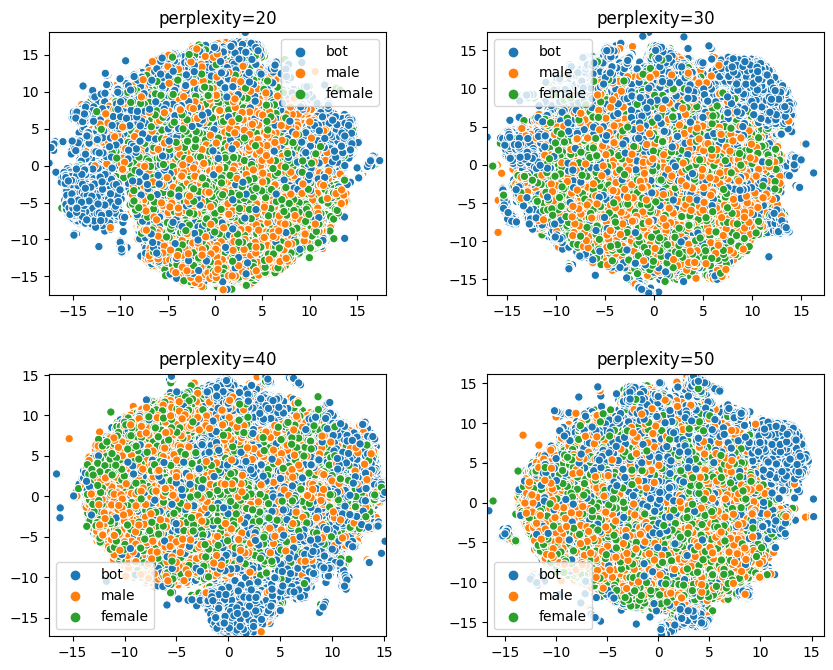

In [0]:
plot_tsne(features_train_pca_1, classes_train)

In [0]:
plot_tsne(features_train_pca_2, classes_train)